In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pathlib import Path
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(14, 6))
sns.mpl.rc("font", size=14)

### Load Data


In [3]:
gdp_file_name = "gdp_clean.csv"
processed_data_path = Path.cwd().parent / "data" / "processed"
file_path = processed_data_path / gdp_file_name
gdp_df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

gdp_df.head()

,value
date,
2003-10-01,441827
2004-01-01,443792
2004-04-01,446140
2004-07-01,447205
2004-10-01,448619


### EDA


In [4]:
# Create a complete date range from start to end of your data
complete_date_range = pd.date_range(
    start=gdp_df.index.min(), end=gdp_df.index.max(), freq="QS"
)

# Find missing dates by comparing the complete date range to your data's date index
missing_dates = complete_date_range.difference(gdp_df.index)

if not missing_dates.empty:
    print(f"Missing dates: {missing_dates.strftime('%Y-%m').tolist()}")
else:
    print("No missing dates.")

No missing dates.


In [5]:
# Get summary statistics
gdp_df.describe()

,value
count,79.000000
mean,500697.746835
std,38430.545664
min,431794.000000
25%,469543.500000
50%,487845.000000
75%,538584.500000
max,561480.000000


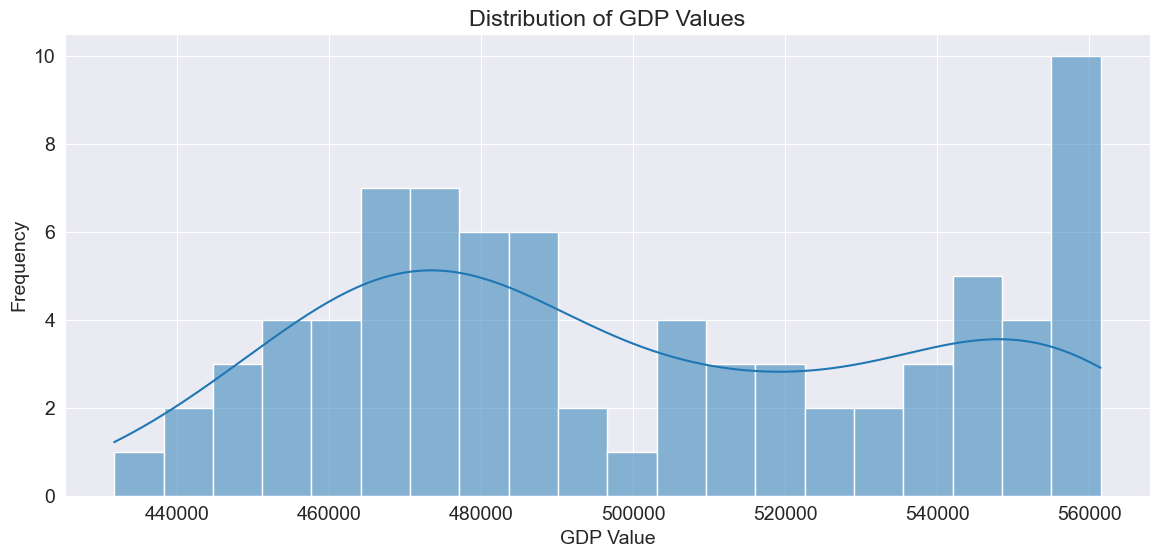

In [6]:
# Plot histogram to visualize the distribution of GDP values
sns.histplot(gdp_df["value"], bins=20, kde=True)
plt.title("Distribution of GDP Values")
plt.xlabel("GDP Value")
plt.ylabel("Frequency")
plt.show()

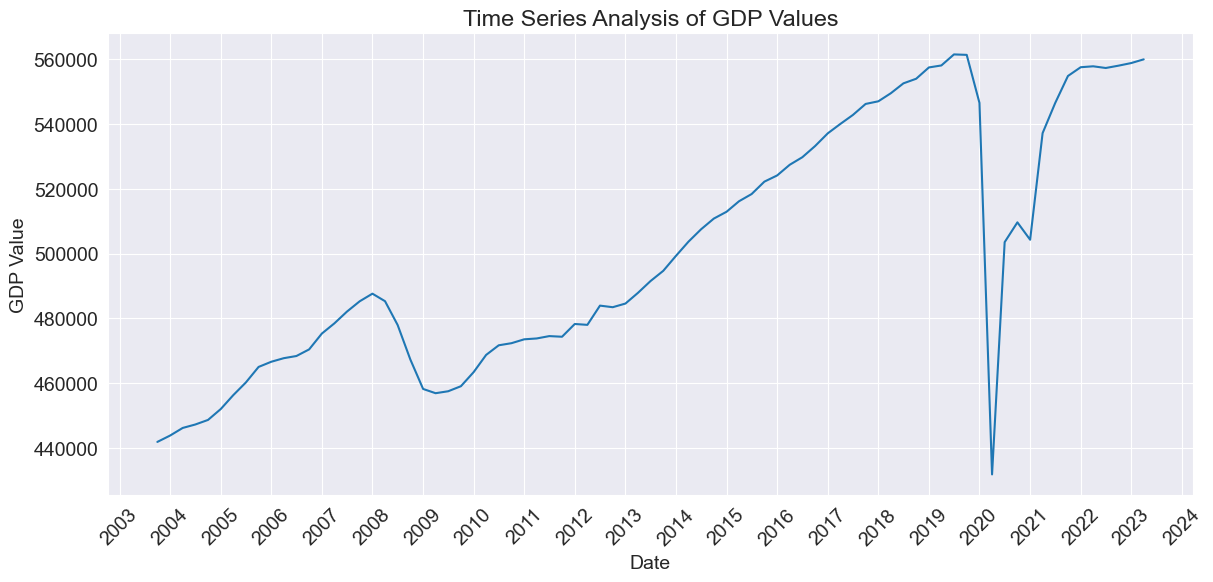

In [7]:
# Plot time series to understand trends and patterns
sns.lineplot(x=gdp_df.index, y="value", data=gdp_df)
plt.title("Time Series Analysis of GDP Values")
plt.xlabel("Date")
plt.ylabel("GDP Value")
# Format x-tick labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.show()

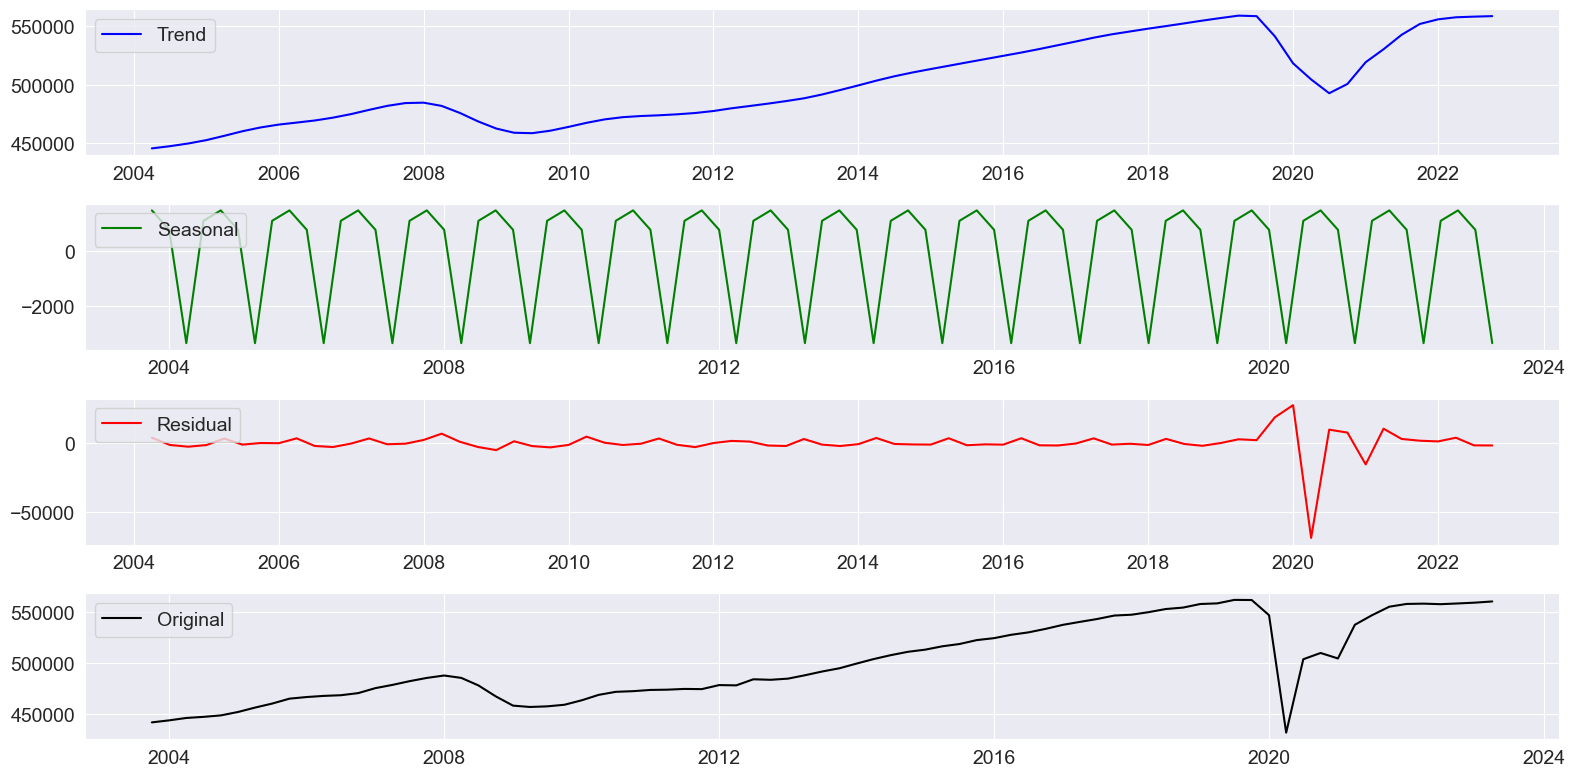

In [8]:
# Decompose the time series into Trend, Seasonality, and Residual components
decomposition = seasonal_decompose(gdp_df["value"], model="additive", period=4)

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(decomposition.trend, label="Trend", color="blue")
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(decomposition.seasonal, label="Seasonal", color="green")
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(decomposition.resid, label="Residual", color="red")
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(gdp_df["value"], label="Original", color="black")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

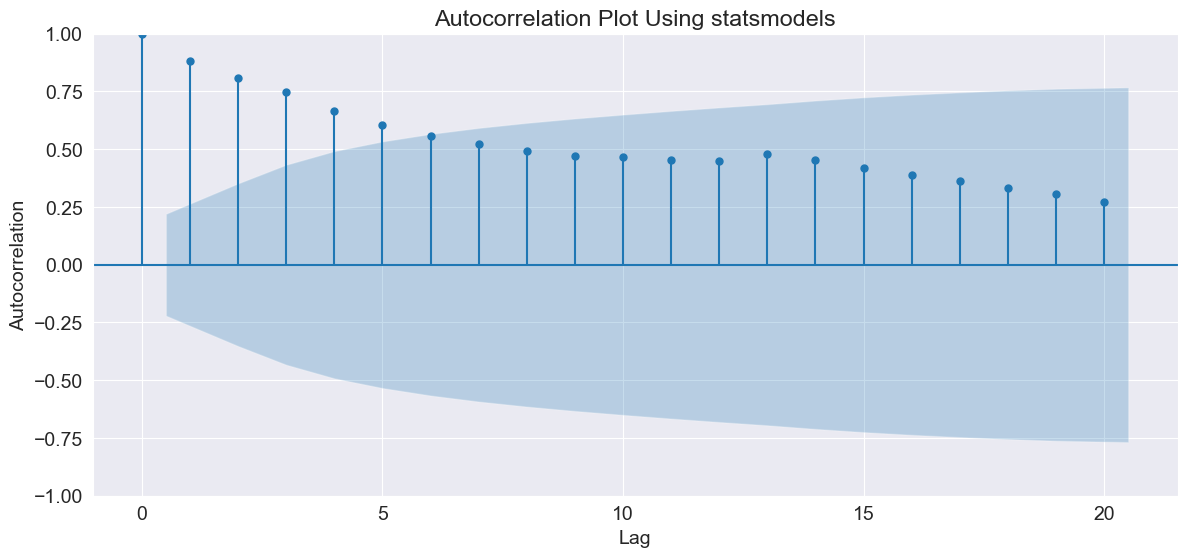

In [9]:
# Check for seasonal patterns using autocorrelation
plot_acf(gdp_df["value"], lags=20)
plt.title("Autocorrelation Plot Using statsmodels")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [19]:
# Inspect lagged correlation
shifted_df = pd.concat([gdp_df.shift(1), gdp_df], axis=1)
shifted_df.columns = ["t-1", "t"]

shifted_df.corr()

,t-1,t
t-1,1.000000,0.908495
t,0.908495,1.000000


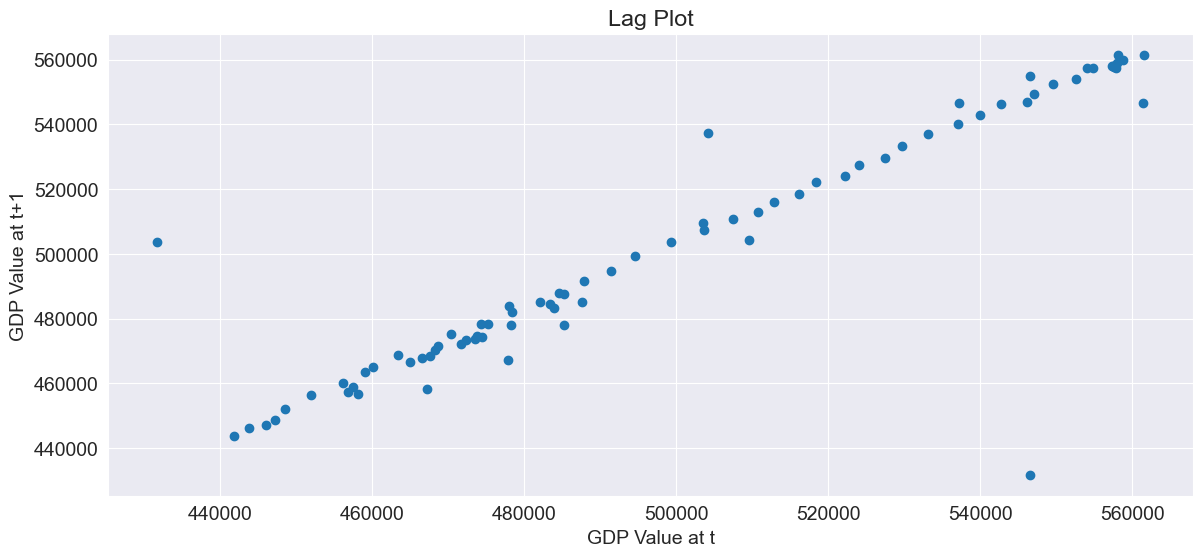

In [11]:
# Create a lag plot to check for autocorrelation
lag_plot(gdp_df["value"], lag=1)
plt.title("Lag Plot")
plt.xlabel("GDP Value at t")
plt.ylabel("GDP Value at t+1")
plt.show()

In [12]:
# Stationarity Check Using Augmented Dickey-Fuller Test
adf_result = adfuller(gdp_df["value"])
print(f"ADF Statistic: {adf_result[0]:.2f}")
print(f"p-value: {adf_result[1]:.3f}")
print("Critical Values:", adf_result[4])

if adf_result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -1.46
p-value: 0.551
Critical Values: {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
The time series is not stationary.


In [13]:
# Apply differencing to make the data stationary
gdp_df_diff = gdp_df.diff().dropna()

# Run ADF test on differenced data
adf_result_diff = adfuller(gdp_df_diff)
adf_stat_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]

print(f"ADF Statistic: {adf_result_diff[0]:.2f}")
print(f"p-value: {adf_result_diff[1]:.3f}")
print("Critical Values:", adf_result_diff[4])

if adf_result_diff[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -11.40
p-value: 0.000
Critical Values: {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
The time series is stationary.


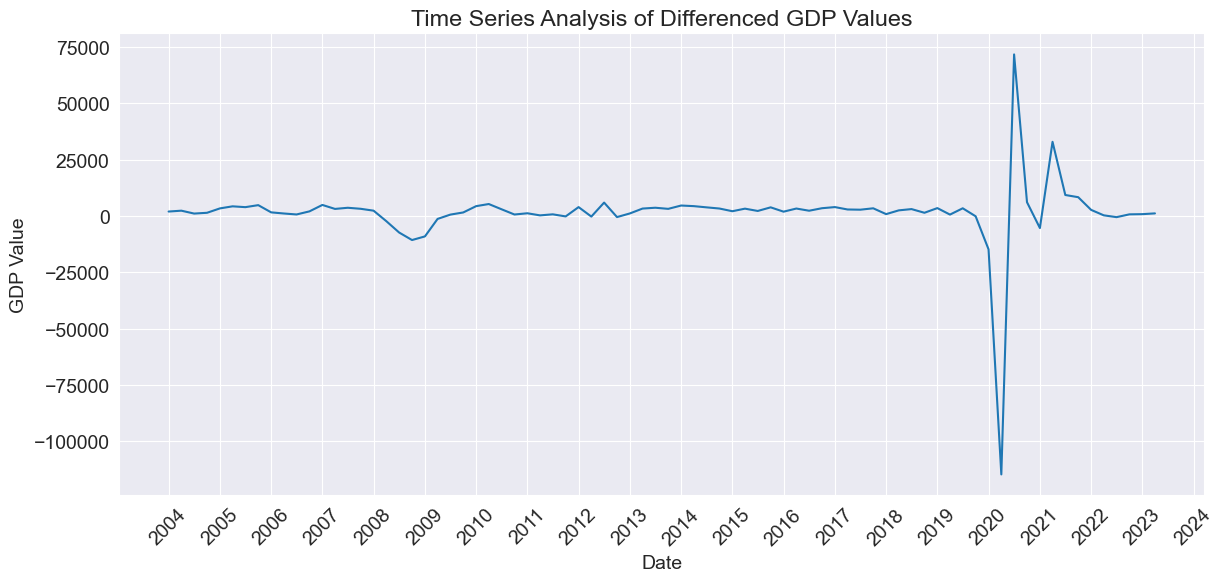

In [14]:
# Plot differenced time series
sns.lineplot(x=gdp_df_diff.index, y="value", data=gdp_df_diff)
plt.title("Time Series Analysis of Differenced GDP Values")
plt.xlabel("Date")
plt.ylabel("GDP Value")
# Format x-tick labels
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.show()